# Creation of a custom network based on MemNet
Keras library is used to create a MemNet-like network, in order to be able to both reduce blur and increase the size of the images.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import random
import sys
import time
import pickle
import importlib

from scipy import ndimage
#NN package
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
from tensorflow.keras import utils

from tensorflow.keras.utils import plot_model

import tensorflow.keras.backend as K

In [3]:
#define a weighted average layer
class custom_avg(keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1]),
            initializer=keras.initializers.Ones(),
            trainable=True,
        )
    def call(self, inputs):
        w_inputs = tf.math.multiply(inputs, self.w)
        return tf.math.reduce_mean(w_inputs, axis=-1, keepdims=False, name=None)


#define a feature extractor
def feature_extration(layer_in, depth = 1, n_channels=64,dropout=0.0):
    for i in range(depth):
        conv = layers.Conv2D(n_channels, kernel_size=3, activation='relu',padding='same')(layer_in)
        drop = layers.SpatialDropout2D(dropout)(conv)
        layer_in = drop
    return layer_in


def recursive_unit(layer_in, recursion, n_channels):
    norm = layers.BatchNormalization()
    act = layers.Activation('relu')
    conv1 = layers.Conv2D(n_channels, 3,padding='valid',activation='relu')
    conv2 = layers.Conv2D(n_channels,3,padding='valid')
    #recursive unit
    prev_res = layer_in
    for r in range(recursion):
        res = layers.Add()([conv2(conv1(act(norm(prev_res)))),prev_res])
        prev_res = res
        if r >0:
            shortM.append(res)
        else:
            shortM = [res]
    return shortM

def gate(shortM,longM,n_channels):
    norm = layers.BatchNormalization()
    act = layers.Activation('relu')
    conv = layers.Conv2D(n_channels,1,padding='same')
    layer_in = layers.Concatenate()(shortM+longM)
    layer_out = conv(act(norm(layer_in)))
    return layer_out
                    
        
    
#define the memory blocks used by MemNet
def memory_block(longM, recursion, n_channels):
    #recursive unit
    shortM = recursive_unit(longM[-1],recursion, n_channels)
    
    #gate
    newM = gate(shortM,longM,n_channels)
    return newM

#define the main image super-resolution network
def MemNet(layer_in, recursion = 6, memory_blocks = 3, n_channels = 16):
    longM = [layer_in]
    for i in range(memory_blocks):
        newM = memory_block(longM,recursion,n_channels)
        longM.append(newM)
    return longM

#define the reconsctruction net
def reconstruction(Memory, small_img, n_channels=8,ids=404):
    act = layers.Activation('relu')
    conv1 = layers.Conv2D(n_channels,3,padding='same',activation = 'relu',name = 'conv_rec_1')
    #conv2 = layers.Conv2D(n_channels,3,padding='same',activation = 'relu')
    convout = layers.Conv2D(3,3,padding='same',name = 'conv_out')
    #name = 'Memory_'+str(ids)
    image = layers.Add()([convout(conv1(act(Memory))),small_img])
    return image
#weight the different recreation to remake the best possible image
def ensemble(longM):
    expand_dim = layers.Lambda(lambda x: K.expand_dims(x, axis=4))
    expanded_mem = []
    for mem in longM:
        expanded_mem.append(expand_dim(mem))
    concat = layers.Concatenate()(expanded_mem)
    out_img = custom_avg()(concat)
    return out_img

In [4]:
#define a custom padding layer to use reflect padding
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')
#define a custom convolution layer
class ReflectionConv2D(Layer):
    def __init__(self,n_channels = 32,**kwargs):
        super().__init__()
        self.act = layers.Activation('relu')
        self.pad = ReflectionPadding2D()
        self.conv = layers.Conv2D(n_channels,3,padding='valid')
        
    def call(self,inputs):
        activated = self.act(inputs)
        padded = self.pad(activated)
        out = self.conv(padded)
        return out
def feature_extration(layer_in, depth = 1, n_channels=64,dropout=0.0):
    for i in range(depth):
        conv = ReflectionConv2D(n_channels)(layer_in)
        drop = layers.SpatialDropout2D(dropout)(conv)
        layer_in = drop
    return layer_in


def recursive_unit(layer_in, recursion, n_channels):
    norm = layers.BatchNormalization()
    conv1 = ReflectionConv2D(n_channels)
    conv2 = ReflectionConv2D(n_channels)
    #recursive unit
    prev_res = layer_in
    for r in range(recursion):
        res = layers.Add()([conv2(conv1(norm(prev_res))),prev_res])
        prev_res = res
        if r >0:
            shortM.append(res)
        else:
            shortM = [res]
    return shortM

def gate(shortM,longM,n_channels):
    norm = layers.BatchNormalization()
    act = layers.Activation('relu')
    conv = layers.Conv2D(n_channels,1,padding='same')
    layer_in = layers.Concatenate()(shortM+longM)
    layer_out = conv(act(norm(layer_in)))
    return layer_out
                    
        
    
#define the memory blocks used by MemNet
def memory_block(longM, recursion, n_channels):
    #recursive unit
    shortM = recursive_unit(longM[-1],recursion, n_channels)
    
    #gate
    newM = gate(shortM,longM,n_channels)
    return newM

#define the main image super-resolution network
def MemNet(layer_in, recursion = 6, memory_blocks = 3, n_channels = 16):
    longM = [layer_in]
    for i in range(memory_blocks):
        newM = memory_block(longM,recursion,n_channels)
        longM.append(newM)
    return longM

#define the reconsctruction net
def reconstruction(Memory, small_img, n_channels=8,ids=404):
    conv1 = ReflectionConv2D(n_channels)
    #conv2 = layers.Conv2D(n_channels,3,padding='same',activation = 'relu')
    convout = ReflectionConv2D(n_channels = 3)
    #name = 'Memory_'+str(ids)
    image = layers.Add()([convout(conv1(Memory)),small_img])
    return image
#weight the different recreation to remake the best possible image
def ensemble(longM):
    expand_dim = layers.Lambda(lambda x: K.expand_dims(x, axis=4))
    expanded_mem = []
    for mem in longM:
        expanded_mem.append(expand_dim(mem))
    concat = layers.Concatenate()(expanded_mem)
    out_img = custom_avg()(concat)
    return out_img

In [5]:
n_channels = 32
size = 128
visible = layers.Input(shape = (size,size,3),name='image_LR')
features = feature_extration(visible,depth=5,n_channels=n_channels,dropout=0.2)
feat_net = Model(inputs = visible,outputs = features,name = 'features_extraction')
rec_input = layers.Input(shape=(size,size,n_channels))
rec_out = reconstruction(rec_input,visible,n_channels = n_channels)
rec_net = Model(inputs = [rec_input,visible],outputs=rec_out,name='reconstruction')

In [6]:
rec_net.summary()


Model: "reconstruction"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 32 0                                            
__________________________________________________________________________________________________
reflection_conv2d_5 (Reflection (None, 128, 128, 32) 9248        input_1[0][0]                    
__________________________________________________________________________________________________
reflection_conv2d_6 (Reflection (None, 128, 128, 3)  867         reflection_conv2d_5[0][0]        
__________________________________________________________________________________________________
image_LR (InputLayer)           [(None, 128, 128, 3) 0                                            
_____________________________________________________________________________________

In [7]:
#put together the model:
features = feat_net(visible)

memory_blocks = 3
longM = MemNet(features,recursion = 3, memory_blocks = memory_blocks,n_channels=32)

img_l = []
for i,memory in enumerate(longM[1:]):
    img_l.append(rec_net([memory,visible]))
img_f = ensemble(img_l)
MemNetModel_ms = Model(inputs=visible, outputs=(img_l,img_f))
MemNetModel = Model(inputs=visible, outputs=img_f)

In [8]:
MemNetModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_LR (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
features_extraction (Functional (None, 128, 128, 32) 37888       image_LR[0][0]                   
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         features_extraction[0][0]        
                                                                 add_1[0][0]                      
                                                                 add_2[0][0]                      
____________________________________________________________________________________________

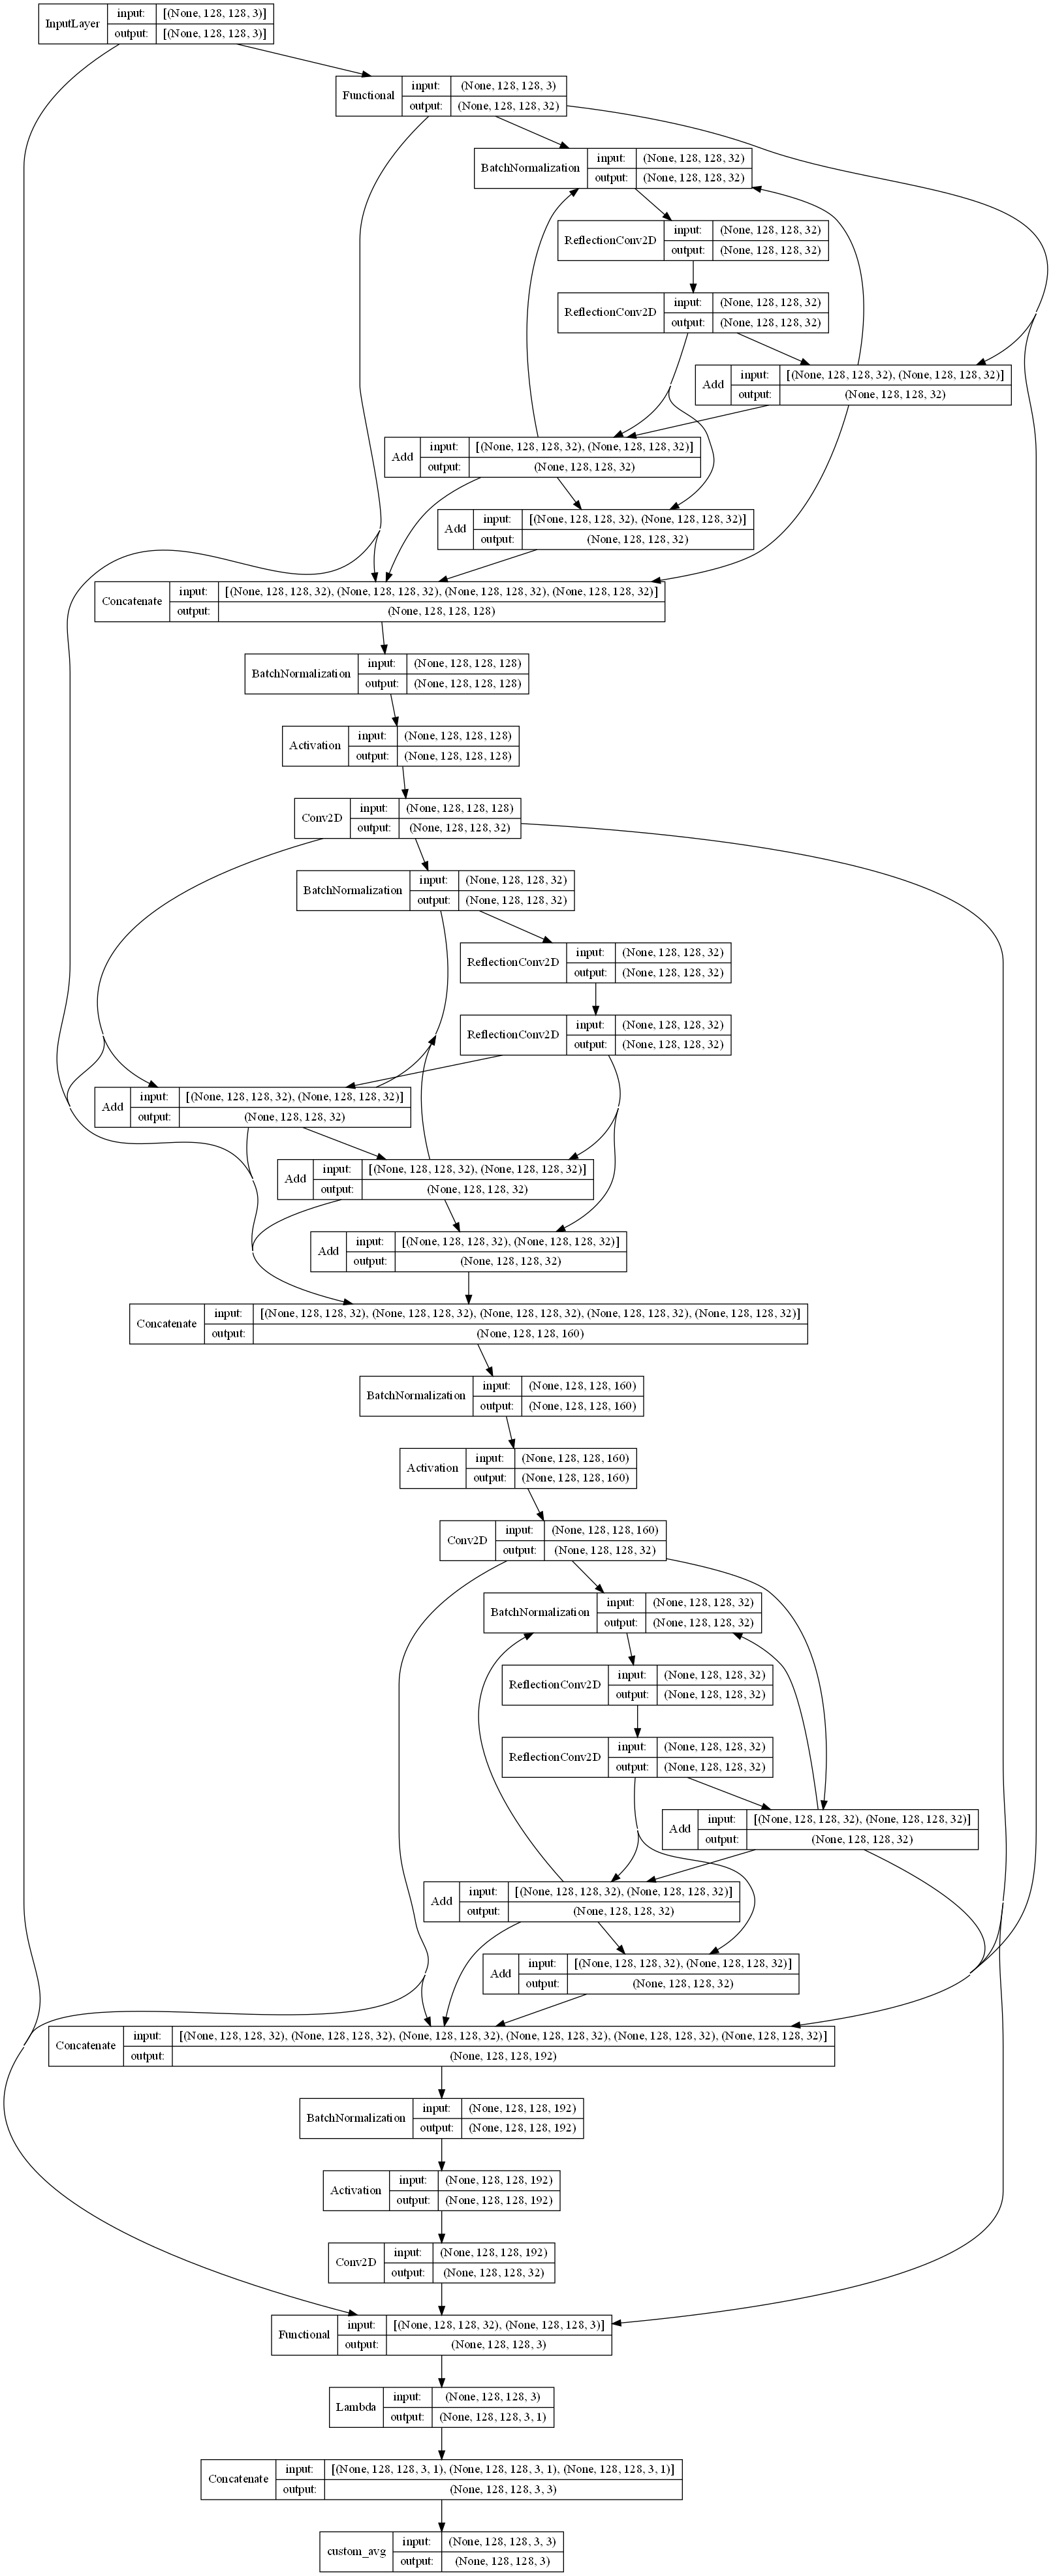

In [10]:
plot_model(MemNetModel_ms, show_shapes=True, show_layer_names=False)

# Dataset creation
Patches of segmented images of size greater than 256 are randomly cut, downsampled and blurred out

In [11]:
data_base_path = os.path.join(os.pardir, 'Datasets')
pickle_folder = os.path.join('PMID2019', 'pickle_ROI')
pickle_path = os.path.join(data_base_path, pickle_folder)
with open(os.path.join(pickle_path,'crops_dark1.pickle'),'rb') as f:
    ROI_list = pickle.load(f)

In [12]:
len(ROI_list)

728

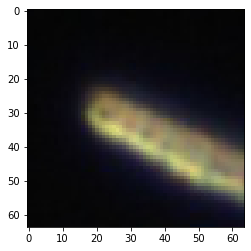

In [13]:
plt.imshow(ROI_list[1])

In [14]:
img = ROI_list[1]

In [15]:
result = tf.image.random_crop(value=img, size=(256, 256,3))
blur = ndimage.uniform_filter(result, size=(15, 15, 1))

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'Need value.shape >= size, got '
64, 64, 3
256, 256, 3

NameError: name 'result' is not defined

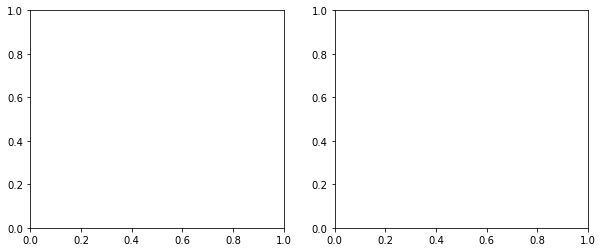

In [16]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))
ax[0].imshow(result)
ax[1].imshow(blur)
plt.show()

In [17]:
sample = ROI_list[0:10]

In [18]:
#use the already cropped images:
with open(os.path.join(pickle_path,'crops_small1.pickle'),'rb') as f:
    crop_list = pickle.load(f)

In [19]:
len(crop_list)

47160

In [20]:
def standardize(img,mean=None,var=None,epsilon = 0.0001):
    if mean is None:
        mean = np.mean(img)
    meanless = img-mean
    if var is None:
        var = np.mean(np.square(meanless))
    
    img_n = meanless/(var+epsilon)
    return img_n
def destand(img_n, perc = 1,epsilon = 0.0001):
    pl,ph = np.percentile(img_n, [perc,100-perc])
    img = np.array((img_n-pl)/(epsilon+ph-pl))
    img[img>1]=1
    img[img<0]=0
    return img

In [21]:
def dataset_generator(ROI_list=ROI_list, sigma = 15,patch_size=256):
    n = 0
    while n < len(ROI_list):
        result = tf.cast(tf.image.random_crop(value=ROI_list[n], size=(patch_size, patch_size,3)),float)
        blur = ndimage.uniform_filter(result, size=(sigma, sigma, 1))
        mean = np.mean(blur)
        meanless = blur-mean
        absmin = abs(np.min(meanless))
        absmax = np.max(meanless)
        if absmax<absmin:
            blur_n = meanless/absmin
            result_n = (result-mean)/absmin
        else:
            blur_n = meanless/absmax
            result_n = (result-mean)/absmax
        yield (blur_n,result_n)
        n+=1
def dataset_generator_from_crop(crop_list = crop_list, sigma = 10):
    n = 0
    np.random.shuffle(crop_list) 
    while n<len(crop_list):
        img = crop_list[n]
        blur = ndimage.uniform_filter(img, size=(sigma, sigma, 1))
        std_img = standardize(img)
        std_blur = standardize(blur)
        yield(std_blur,std_img)
        n+=1
def dataset_generator_scaling(crop_list = crop_list,size=[2,3,4],size_ori = 128):
    n = 0
    np.random.shuffle(crop_list) 
    while n<len(crop_list):
        s = np.random.choice(size)
        img = crop_list[n]
        img_small = tf.image.resize(img, (size_ori//s,size_ori//s), preserve_aspect_ratio=True)
        img_bic = tf.image.resize(img, (size_ori,size_ori), preserve_aspect_ratio=True)
        std_img = standardize(img)
        std_bic = standardize(img_bic)
        yield(std_bic,std_img)
        n+=1

TypeError: only size-1 arrays can be converted to Python scalars

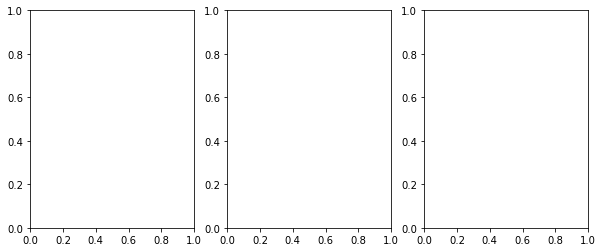

In [22]:
i=0
for data in dataset_generator_scaling(size_ori=128):
    fig, ax = plt.subplots(1,3, figsize=(10, 4))
    ax[0].imshow(float((data[0]-np.min(data[0]))/(np.max(data[0])-np.min(data[0]))))
    ax[1].imshow(float(data[1]-np.min(data[1]))/(np.max(data[1])-np.min(data[1])))
    ax[2].imshow(destand(data[1]-data[0]))
    plt.show()
    i+=1
    if i>10:
        break

In [23]:
#datasets for denoizing
dataset = tf.data.Dataset.from_generator(dataset_generator,
                                         output_signature =(tf.TensorSpec(shape=(size,size,3), dtype=tf.float32),
                                                            tf.TensorSpec(shape=(size,size,3), dtype=tf.float32)))
batch_size = 4
dataset = dataset.batch(batch_size)
dataset_from_crop = tf.data.Dataset.from_generator(dataset_generator_from_crop,
                                         output_signature =(tf.TensorSpec(shape=(size,size,3), dtype=tf.float32),
                                                            tf.TensorSpec(shape=(size,size,3), dtype=tf.float32)))
dataset_from_crop = dataset_from_crop.batch(batch_size)

In [24]:
#datasets for upscalling
batch_size = 8
dataset_scaling = tf.data.Dataset.from_generator(dataset_generator_scaling,
                                         output_signature =(tf.TensorSpec(shape=(size,size,3), dtype=tf.float32),
                                                            tf.TensorSpec(shape=(size,size,3), dtype=tf.float32)))
dataset_scaling = dataset_scaling.batch(batch_size)

In [25]:
MemNetModel.compile(optimizer = 'Adam',loss = 'MeanSquaredError')
loss_list = []
alpha = 0.8
for i in range(memory_blocks):
    loss_list.append((1-alpha)/(memory_blocks))
loss_list.append(alpha)
MemNetModel_ms.compile(optimizer = 'Adam',loss ='MeanSquaredError',loss_weights=loss_list)
MemNetModel_ms.load_weights('Model_weights/super_res1.h5')

In [ ]:
history = MemNetModel_ms.fit(x=dataset_scaling, epochs=5)

Epoch 1/5
     23/Unknown - 19s 512ms/step - loss: 6.1205e-08 - reconstruction_loss: 6.2667e-08 - reconstruction_1_loss: 6.1585e-08 - reconstruction_2_loss: 6.0920e-08 - custom_avg_loss: 6.1075e-08

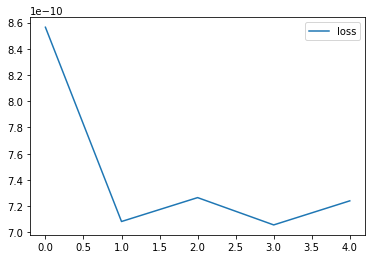

In [221]:
loss = history.history['loss']
#val_loss = history.history['val_loss']
plt.plot(loss)
#plt.plot(val_loss)
plt.legend(('loss','val_loss'))

In [222]:
MemNetModel_ms.save_weights('Model_weights/xxxxxx.h5')


In [245]:
np.mean(out[1][0]-data[0][1][0],axis=(0,1))

array([ 1.1257951e-05, -8.7720664e-06,  5.9808344e-06], dtype=float32)

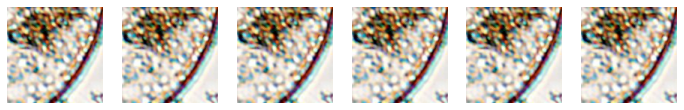

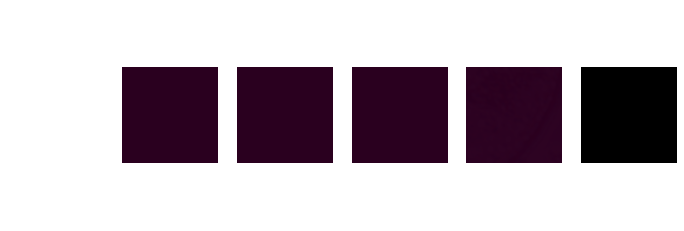

In [237]:
data = list(dataset_scaling.take(1))
out = MemNetModel_ms.predict(data[0][0])
fig, ax = plt.subplots(1,memory_blocks+3, figsize=(12, 4))
for el in ax: el.axis('off')
ax[0].imshow(destand(data[0][0][0]))
for mem in range(memory_blocks):
    ax[mem+1].imshow(destand(out[0][mem][0]))
ax[-2].imshow(destand(out[1][0]))
ax[-1].imshow(destand(data[0][1][0]))
plt.show()

fig, ax = plt.subplots(1,memory_blocks+3, figsize=(12, 4))
for mem in range(memory_blocks):
    ax[mem+1].imshow(destand(out[0][mem][0]-data[0][0][0]))
ax[-2].imshow(destand(out[1][0]-data[0][0][0]))
ax[-1].imshow(destand(data[0][1][0]-data[0][0][0]))
for el in ax: el.axis('off')
plt.show()



In [ ]:
diff = out[0][3][0]
diff_n = (diff-np.min(diff))/(np.max(diff)-np.min(diff))

In [ ]:
plt.imshow(diff_n)

In [83]:
np.min(diff)

-0.97577006

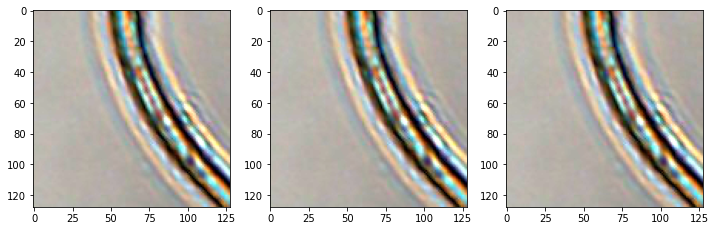

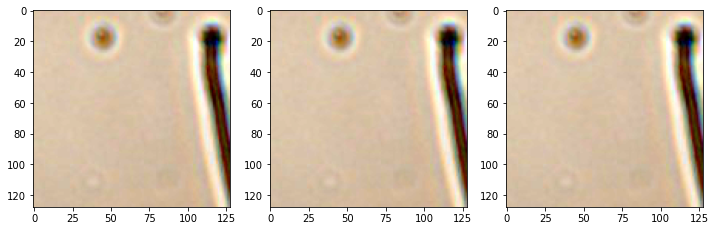

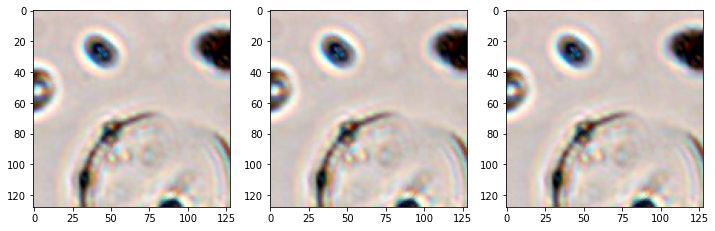

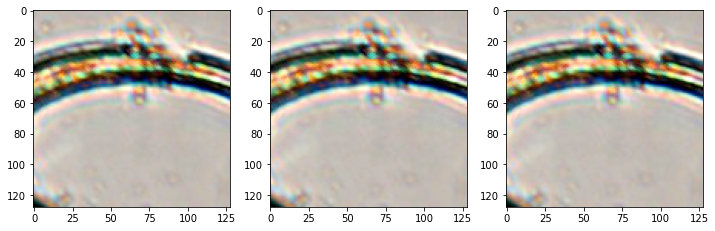

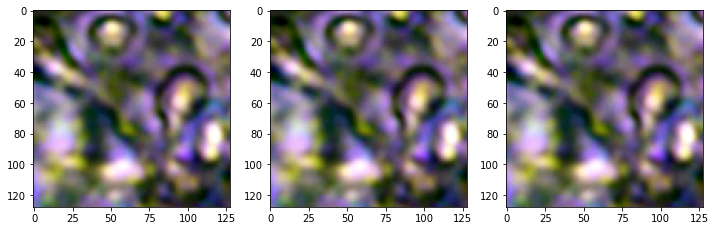

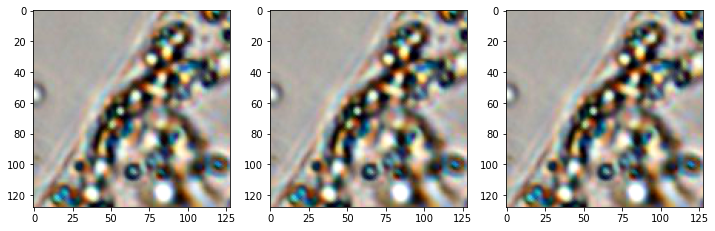

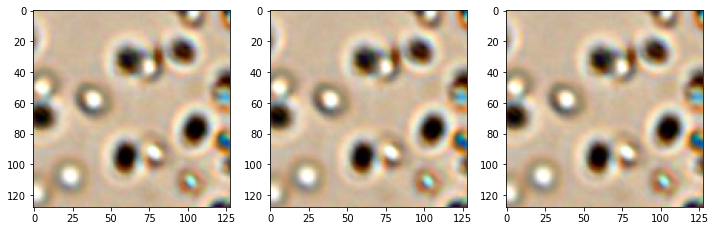

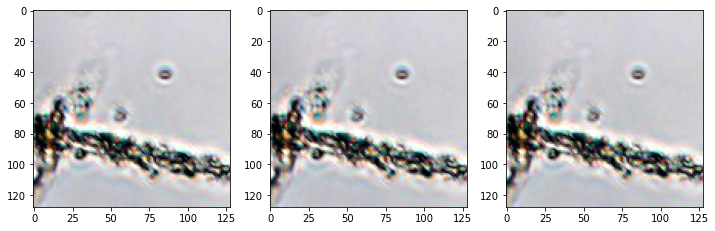

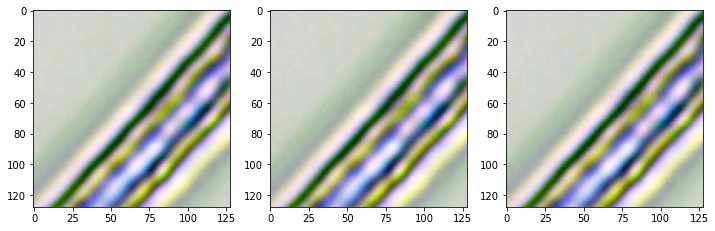

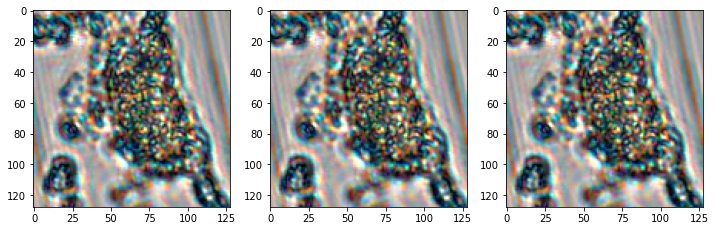

In [153]:

for data in dataset_scaling.take(10):
    fig, ax = plt.subplots(1,3, figsize=(12, 4))
    ax[0].imshow(destand(list(data)[0][0]))
    #print(MemNetModel_ms.predict(data[0])[0])
    ax[1].imshow(destand(MemNetModel_ms.predict(data[0])[1][0]))
    ax[2].imshow(destand(list(data)[1][0]))
    #print(np.max(abs(list(data)[0][0]-MemNetModel_ms.predict(data[0])[0][-1][0])))
    plt.show()


Test super-resolution:

In [190]:
n_channels = 32
size = 1024
visible_big = layers.Input(shape = (size,size,3),name='image_LR')
features = feature_extration(visible_big,depth=5,n_channels=n_channels,dropout=0.2)
feat_net = Model(inputs = visible_big,outputs = features,name = 'features_extraction')
rec_input = layers.Input(shape=(size,size,n_channels))
rec_out = reconstruction(rec_input,visible_big,n_channels = n_channels)
rec_net = Model(inputs = [rec_input,visible_big],outputs=rec_out,name='reconstruction')
 #put together the model:
features_big = feat_net(visible_big)

memory_blocks = 3
longM_big = MemNet(features_big,recursion = 3, memory_blocks = memory_blocks,n_channels=32)

img_l_big = []
for i,memory in enumerate(longM_big[1:]):
    img_l_big.append(rec_net([memory,visible_big]))
img_f_big = ensemble(img_l_big)
MemNetModel_big = Model(inputs=visible_big, outputs=img_f_big)
MemNetModel_big.compile(optimizer = 'Adam',loss = 'MeanSquaredError')
MemNetModel_big.load_weights('Model_weights/super_res1.h5')

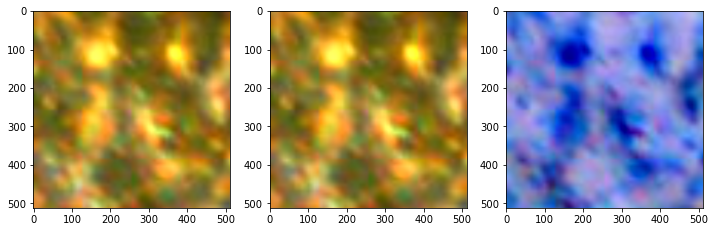

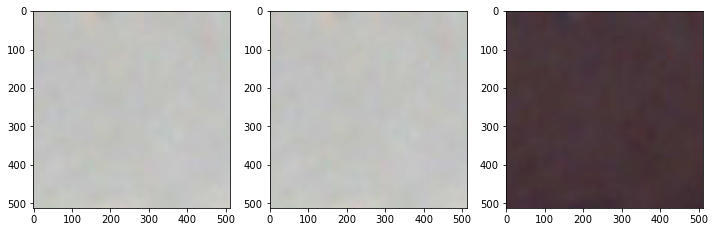

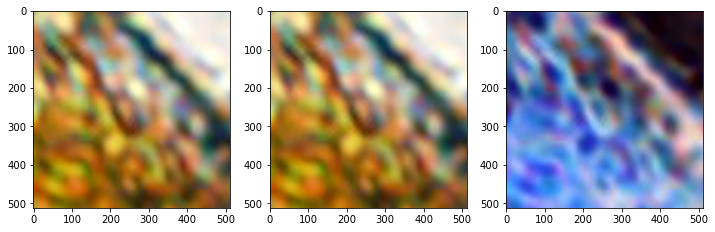

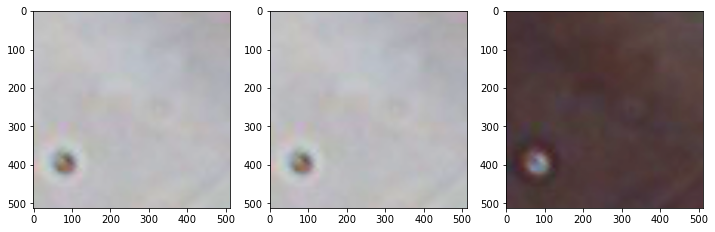

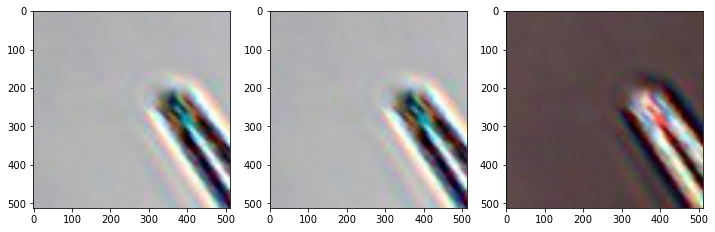

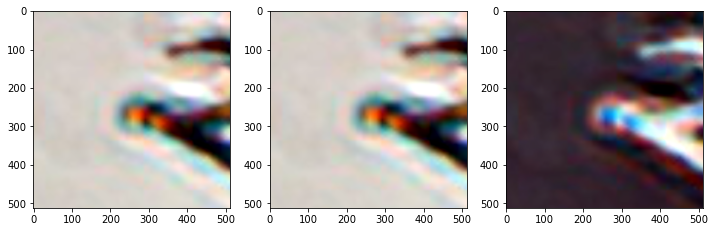

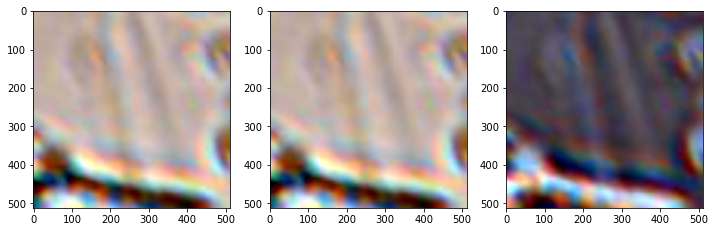

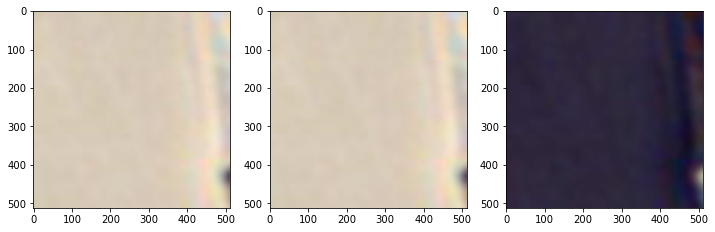

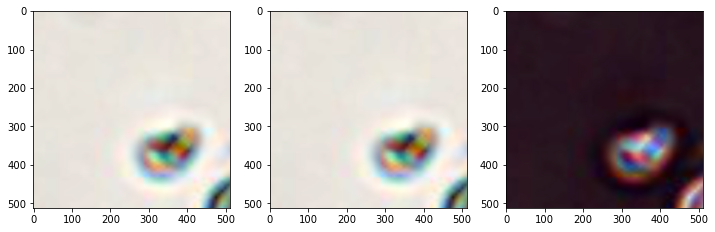

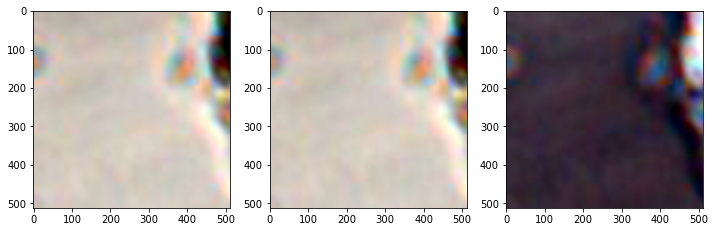

In [226]:
batch_size_inf = 1
dataset_scaling_inf = dataset_scaling.batch(batch_size_inf)
for data in crop_list[:10]:
    fig, ax = plt.subplots(1,3, figsize=(12, 4))
    img_bic = tf.image.resize(data, (1024,1024), preserve_aspect_ratio=True)
    ax[0].imshow(destand(img_bic)[:512,:512])
    ax[1].imshow(destand(MemNetModel_big.predict(np.array([img_bic]))[0])[:512,:512])
    ax[2].imshow(destand(img_bic-MemNetModel_big.predict(np.array([img_bic]))[0])[:512,:512])
    plt.show()

In [186]:
len(crop_list)

47160